- Reference <br>
https://www.kaggle.com/szuzhangzhi/vision-transformer-vit-cuda-as-usual/data

I made a notebook by dividing it into [Train] and [Inference] parts by referring to the original notebook.

### Please upvote original notebook :)

In [1]:
# !pip install vision_transformer_pytorch
# !pip install AdamP

In [2]:
import sys

package_path = '../input/vision-transformer-pytorch/VisionTransformer-Pytorch'
sys.path.append(package_path)

## Library

In [3]:
import os
import pandas as pd

import time
import datetime
import copy
import matplotlib.pyplot as plt
import json
import seaborn as sns
import cv2
import albumentations as albu
import numpy as np

import torch
import torch.nn as nn
import torchvision.models as models
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torch.optim.lr_scheduler import ReduceLROnPlateau
from sklearn.metrics import accuracy_score
from sklearn.model_selection import StratifiedKFold, GroupKFold, KFold, train_test_split


# ALBUMENTATIONS
import albumentations as albu

from albumentations import (
    HorizontalFlip, VerticalFlip, IAAPerspective, ShiftScaleRotate, CLAHE, RandomRotate90,
    Transpose, ShiftScaleRotate, Blur, OpticalDistortion, GridDistortion, HueSaturationValue,
    IAAAdditiveGaussianNoise, GaussNoise, MotionBlur, MedianBlur, IAAPiecewiseAffine, RandomResizedCrop,
    IAASharpen, IAAEmboss, RandomBrightnessContrast, Flip, OneOf, Compose, Normalize, Cutout, CoarseDropout, ShiftScaleRotate, CenterCrop, Resize
)
    
from albumentations.pytorch import ToTensorV2

# ADAMP
# from adamp import AdamP

In [4]:
BASE_DIR="../input/cassava-leaf-disease-classification/"
TRAIN_IMAGES_DIR = os.path.join(BASE_DIR,'train_images')

In [5]:
train_df = pd.read_csv(os.path.join(BASE_DIR, 'train.csv'))
train_df.head()

,image_id,label
0,1000015157.jpg,0
1,1000201771.jpg,3
2,100042118.jpg,1
3,1000723321.jpg,1
4,1000812911.jpg,3


In [6]:
print("Count of training images {0}".format(len(os.listdir(TRAIN_IMAGES_DIR))))

Count of training images 21397


In [7]:
with open(f'{BASE_DIR}/label_num_to_disease_map.json', 'r') as f:
    name_mapping = json.load(f)
    
name_mapping = {int(k): v for k, v in name_mapping.items()}
train_df['class_id'] = train_df['label'].map(name_mapping)

In [8]:
name_mapping

{0: 'Cassava Bacterial Blight (CBB)',
 1: 'Cassava Brown Streak Disease (CBSD)',
 2: 'Cassava Green Mottle (CGM)',
 3: 'Cassava Mosaic Disease (CMD)',
 4: 'Healthy'}

## Visualization

In [9]:
def visualize_images(image_ids, labels):
    plt.figure(figsize=(16, 12))
    
    for idx, (image_id, label) in enumerate(zip(image_ids, labels)):
        plt.subplot(3, 3, idx+1)
        
        image = cv2.imread(os.path.join(TRAIN_IMAGES_DIR, image_id))
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        
        plt.imshow(image)
        plt.title(f"Class: {label}", fontsize=12)
        
        plt.axis("off")
        
    plt.show()
    

def plot_augmentation(image_id, transform):
    plt.figure(figsize=(16, 4))
    
    img = cv2.imread(os.path.join(TRAIN_IAMGES_DIR, image_id))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    plt.subplot(1, 3, 1)
    plt.imshow(img)
    plt.axis('off')
    
    plt.subplot(1, 3, 2)
    x = transform(image=img)['image']
    plt.imshow(x)
    plt.axis('off')
    
    plt.subplot(1, 3, 3)
    x = transform(image=img)['image']
    plt.imshow(x)
    
def visualize(images, transform):
    '''
    Plot images and their transformations
    '''
    fig = plt.figure(figsize=(32, 16))
    
    for i, im in enumerate(images):
        ax = fig.add_subplot(2, 5, i+1, xticks=[], yticks=[])
        plt.imshow(im)
        
    for i, im in enumerate(images):
        ax = fig.add_subplot(2, 5, i+6, xticks=[], yticks=[])
        plt.imshow(transform(image=im)['image'])

## Modeling

In [10]:
# CUSTOM DATASET CLASS
class CassavaDataset(Dataset):
    def __init__(
        self, df:pd.DataFrame, imfolder:str, train:bool=True, transforms=None
    ):
        self.df = df
        self.imfolder = imfolder
        self.train = train
        self.transforms = transforms
        
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, index):
        im_path = os.path.join(self.imfolder, self.df.iloc[index]['image_id'])
        im = cv2.imread(im_path, cv2.IMREAD_COLOR)
        im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
        
        if (self.transforms):
            '''
            When AlbumentationCompose, a dictionary with key 'image' is created
            '''
            im = self.transforms(image=im)['image']
            
        if (self.train):
            label = self.df.iloc[index]['label']
            return im, label
        else:
            return im

In [11]:
# AUGMENTATIONS
train_augs = albu.Compose([
    albu.RandomResizedCrop(height=384, width=384, p=1.0),
    albu.HorizontalFlip(p=0.5),
    albu.VerticalFlip(p=0.5),
    albu.RandomBrightnessContrast(p=0.5),
    albu.ShiftScaleRotate(p=0.5),
    albu.Normalize(    
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225],),
    CoarseDropout(p=0.5),
    Cutout(p=0.5),
    ToTensorV2(),
])

valid_augs = albu.Compose([
    albu.Resize(height=384, width=384, p=1.0),
    albu.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225],),
    ToTensorV2(),
])

In [12]:
# DATA SPLIT
train, valid = train_test_split(
    train_df,
    test_size=0.1,
    random_state=42,
    stratify=train_df.label.values
)

# reset index on both dataframes
train = train.reset_index(drop=True)
valid = valid.reset_index(drop=True)

# targets in train,valid datasets
train_targets = train.label.values
valid_targets = valid.label.values

In [13]:
# DEFINE PYTORCH CUSTOM DATASET
train_dataset = CassavaDataset(
    df = train,
    imfolder = TRAIN_IMAGES_DIR,
    train = True,
    transforms = train_augs
)

valid_dataset = CassavaDataset(
    df = valid,
    imfolder = TRAIN_IMAGES_DIR,
    train=True,
    transforms = valid_augs
)

In [14]:
def plot_image(img_dict):
    image_tensor = img_dict[0]
#     print(type(image_tensor))
    target = img_dict[1]
    print(target)
    plt.figure(figsize=(10, 10))
    image = image_tensor.permute(1, 2, 0)
    plt.imshow(image)

1


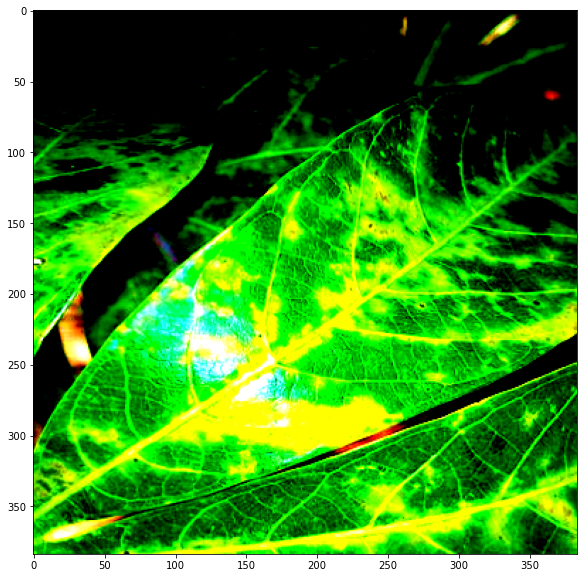

In [15]:
plot_image(train_dataset[5])

In [16]:
# MAKE PYTORCH DATALOADER
train_loader = DataLoader(
    train_dataset,
    batch_size = 16,
    num_workers = 4,
    shuffle = True
)

valid_loader = DataLoader(
    valid_dataset,
    batch_size = 16,
    num_workers = 4,
    shuffle = False
)

In [17]:
# TRAIN
def train_model(datasets, dataloaders, model, criterion, optimizer, scheduler, num_epochs, device):
    since = time.time()
    
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    
    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs-1))
        print('-' * 10)
        
        for phase in ['train', 'valid']:
            if phase == 'train':
                model.train()
            else:
                model.eval()
                
            running_loss = 0.0
            running_corrects = 0.0
            
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)
                
                # Zero out the grads
                optimizer.zero_grad()
                
                # Forward
                # Track history in train mode
                with torch.set_grad_enabled(phase == 'train'):
                    model = model.to(device)
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1) 
                    loss = criterion(outputs, labels)
                    
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                
                # Statistics
                running_loss += loss.item()*inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            
            if phase == 'train':
                scheduler.step()
                
            epoch_loss = running_loss / len(datasets[phase])
            epoch_acc = running_corrects.double() / len(datasets[phase])
            
            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))
            
            if phase == 'valid' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
        
        print()
    
    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:.4f}'.format(best_acc))
    
    model.load_state_dict(best_model_wts)
    
    return model

In [18]:
from vision_transformer_pytorch import VisionTransformer
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

datasets = {'train': train_dataset,
            'valid': valid_dataset}

dataloaders = {'train': train_loader,
               'valid': valid_loader}

# LOAD PRETRAINED ViT MODEL
model = VisionTransformer.from_pretrained('ViT-B_16', num_classes=5)        

# OPTIMIZER
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4, weight_decay=0.001)
# optimizer = torch.optim.Adam(model.parameters(), lr=1e-4, weight_decay=0.001)
# optimizer = AdamP(model.parameters(), lr=1e-4, weight_decay=0.001)

# LEARNING RATE SCHEDULER
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=2, gamma=0.1)

criterion = nn.CrossEntropyLoss()
num_epochs = 6

Downloading: "https://github.com/tczhangzhi/VisionTransformer-PyTorch/releases/download/1.0.1/ViT-B_16_imagenet21k_imagenet2012.pth" to /root/.cache/torch/hub/checkpoints/ViT-B_16_imagenet21k_imagenet2012.pth


  0%|          | 0.00/331M [00:00<?, ?B/s]

Loaded pretrained weights for ViT-B_16


In [19]:
# MODEL TRAIN
trained_model = train_model(datasets, dataloaders, model, criterion, optimizer, scheduler, num_epochs, device)

Epoch 0/5
----------
train Loss: 0.5422 Acc: 0.8104
valid Loss: 0.4553 Acc: 0.8449

Epoch 1/5
----------
train Loss: 0.4452 Acc: 0.8477
valid Loss: 0.4833 Acc: 0.8276

Epoch 2/5
----------
train Loss: 0.3560 Acc: 0.8772
valid Loss: 0.3654 Acc: 0.8752

Epoch 3/5
----------
train Loss: 0.3287 Acc: 0.8857
valid Loss: 0.3627 Acc: 0.8766

Epoch 4/5
----------
train Loss: 0.3144 Acc: 0.8912
valid Loss: 0.3374 Acc: 0.8846

Epoch 5/5
----------
train Loss: 0.3099 Acc: 0.8922
valid Loss: 0.3355 Acc: 0.8855

Training complete in 123m 5s
Best val Acc: 0.8855


In [20]:
# Save the mode after training
torch.save(model.state_dict(), 'vit_b-16.pt')

## Inference: https://www.kaggle.com/nevret93/cassava-vit-cuda-inference